In [1]:
import os
import sys
sys.path.append('..')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medpy.io import load as load_lbl
import random 

from dicomhd import io as dhd_io

from tfvpc.preprocessing.two_dim import extract_2d_patch
from tfvpc.preprocessing.two_dim import show_tf_batch
from tfvpc.preprocessing.two_dim import extract_2d_patch_labels
from tfvpc.preprocessing.two_dim import extract_annotated_2d_patch
from tfvpc.preprocessing.two_dim import recover_image
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import _int64_feature
from tfvpc.preprocessing.two_dim import _bytes_feature

%matplotlib inline

In [2]:
n_rows = 32
n_cols = 32
strides = 1
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
pwd

'/home/ubuntu/project/lta/ltavpc/notebooks'

In [4]:
# load image and extract patches
path_img = '../../data/dev/val/input/complete/'
path_lbl = '../../data/dev/val/output/complete/'
img_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-131'
lbl_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-259'

out_test_fname = 'test_rec'
out_path = '../data/tfrecods/'
out_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

In [5]:
lbl_file_path = os.path.join(path_lbl, lbl_fname)
lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
lbl, label_header = load_lbl(lbl_file_path)
lbl = np.swapaxes(lbl,0,2)
# if lbl.sum() > 0:
# get indices for voxels with ann
idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
img_file_path = os.path.join(path_img, img_fname)
img = dhd_io.read_series(img_file_path)

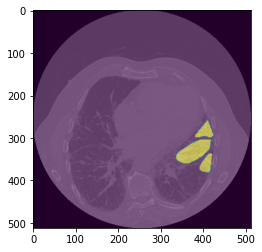

In [6]:
# show GT
sclie_nm = idx_with_ann[20]
plt.imshow(img.pixel_data[sclie_nm], cmap='gray')
plt.imshow(lbl[sclie_nm], alpha=0.5)

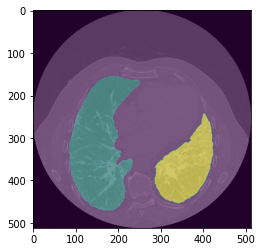

In [10]:
#lung segmentation
out_path = os.path.join(path_lbl, lbl_fname)
# seg_fname = 'lung_mask.nii.gz'
seg_fname = 'segmentation_0.nii.gz'
seg_file_path = os.path.join(out_path, seg_fname)
# img = nib.load(seg_file_path)
seg, seg_header = load_lbl(seg_file_path)
seg = np.swapaxes(seg,0,2)
seg.shape
plt.imshow(img.pixel_data[sclie_nm,...], cmap='gray')
plt.imshow(seg[sclie_nm,...], alpha=0.5)

In [11]:
def crop3Dcenter(data, s2):
    """ crops 3D volume with size s2 from the center
    #args:
    data: 30x48x48 3D volume patch
    s2: ouput volume size after cropping
    returns: Center cropped 3D volume data"""
    s = data.shape
    cr = [int((s[i]-j)/2) for i,j in enumerate(s2)]

    return data[cr[0]:-cr[0],cr[1]:-cr[1],cr[2]:-cr[2]]

def crop_patch_by_center(img, idx, h, w, z=1):
    """Crop patch (h, w, z) form img centerd at idx.
    
    img:
        Image to crop from
    idx:
        Center of the region to crop
    h:
        height
    
    """
    h_st = idx[1] - h//2
    h_end = idx[1] + h//2

    w_st = idx[2] - w//2
    w_end = idx[2] + w//2

    if z > 1:
        z_st = idx[0] - z//2
        z_end = idx[0] + z//2
        img_cropped = img[z_st:z_end+1, h_st:h_end+1, w_st: w_end+1]
    else:
        img_cropped = img[idx[0], h_st:h_end+1, w_st: w_end+1]
    return img_cropped

In [12]:
#patch extraction by centroid
import time
#extract patch within lung region
mask = seg > 0
tf.math.count_nonzero(seg)
# tf.reduce_sum(mask)
# extract indices of lung region
indices = tf.where(mask)
indices.shape
h, w, z = 33, 33, 1
writer = tf.io.TFRecordWriter(out_ffname)
# # loop over indices
for idx in indices[:10]:
    
    t0 = time.time()
    patch_i = crop_patch_by_center(img.pixel_data, idx, h, w, z)
    example = tf.train.Example(
        features=tf.train.Features(feature={
            'img': _bytes_feature(tf.io.serialize_tensor(patch_i).numpy()),
            'idx': _bytes_feature(tf.io.serialize_tensor(idx).numpy()),
        })
    )
    print(idx, time.time() - t0)
    writer.write(example.SerializeToString())
#     break
writer.close()
    

tf.Tensor([ 12 451 195], shape=(3,), dtype=int64) 0.01190495491027832
tf.Tensor([ 12 451 196], shape=(3,), dtype=int64) 0.0012886524200439453
tf.Tensor([ 13 440 210], shape=(3,), dtype=int64) 0.001285552978515625
tf.Tensor([ 13 440 211], shape=(3,), dtype=int64) 0.001264333724975586
tf.Tensor([ 13 446 205], shape=(3,), dtype=int64) 0.0012483596801757812
tf.Tensor([ 13 446 206], shape=(3,), dtype=int64) 0.0012731552124023438
tf.Tensor([ 13 451 195], shape=(3,), dtype=int64) 0.0012500286102294922
tf.Tensor([ 13 451 196], shape=(3,), dtype=int64) 0.001283884048461914
tf.Tensor([ 13 451 197], shape=(3,), dtype=int64) 0.0012431144714355469
tf.Tensor([ 13 452 195], shape=(3,), dtype=int64) 0.0012731552124023438


In [25]:
5000000* 0.0008/60

66.66666666666667

In [22]:
# load tf data
def _parse_image_test(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    image_feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'idx': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _decode_image_test(example):
    example['img'] = tf.io.parse_tensor(example['img'], out_type=tf.int16)
    example['idx'] = tf.io.parse_tensor(example['idx'], out_type=tf.int64)
    return example['img'], example['idx']


def load_test_dataset(fname):
    print(fname)
    dataset = tf.data.TFRecordDataset(fname)
    dataset = dataset.map(_parse_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(_decode_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


data = load_test_dataset(out_ffname)
for elem in data:
    print(elem)
    break

../data/tfrecods/test_rec.tfrecords
(<tf.Tensor: shape=(33, 33), dtype=int16, numpy=
array([[ -48,  172,  218, ..., -184,  -51, -211],
       [ -24,   52,   72, ...,   41,  145, -254],
       [ 147,  164,  -21, ..., -141,   17,   41],
       ...,
       [  25, -165, -125, ..., -215, -274, -273],
       [ -92, -120,  -32, ...,  -90, -109,  -59],
       [ -92, -226, -198, ...,  -44,  -64,   95]], dtype=int16)>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  2, 169, 134])>)


In [86]:
# patch extraction by bounding box
#extract patch within lung region
# mask = seg > 0
# tf.math.count_nonzero(seg)
# # extract indices of lung region
# indices = tf.where(mask)

def get_lung_mask_limits(img, expand_limit=None):
    mask = img > 0
    indices = tf.where(mask)
    img_size = img.shape
    z_min, x_min, y_min = tf.reduce_min(indices, axis=0).numpy().tolist()
    z_max, x_max, y_max = tf.reduce_max(indices, axis=0).numpy().tolist()
    if expand_limit:
        z_min = max(z_min - expand_limit[0], 0)
        x_min = max(x_min - expand_limit[1], 0)
        y_min = max(y_min - expand_limit[2], 0)
        z_max = np.min([z_max + expand_limit[0], img_size[0]])
        x_max = np.min([x_max + expand_limit[1], img_size[1]])
        y_max = np.min([y_max + expand_limit[2], img_size[2]])
    return z_min, x_min, y_min, z_max, x_max, y_max

In [89]:
z_min, x_min, y_min, z_max, x_max, y_max = get_lung_mask_limits(seg, expand_limit=(0, 16, 16))
print(img.pixel_data.shape)
# seg.shape
img_cropped = img.pixel_data[z_min:z_max, x_min:x_max, y_min: y_max]
img_cropped.shape

(229, 512, 512)


(218, 343, 389)

In [ ]:
 arr = np.array(
     [
         list(range(1, 11)),
         list(range(11, 21)),
         list(range(21, 31)),
         list(range(31, 41)),
         list(range(41, 51)),
         list(range(51, 61)),
         list(range(61, 71)),
         list(range(71, 81)),
         list(range(81, 91)),
         list(range(91, 101)),
     ]
 
 )
tnr = tf.constant(arr)
tnr

In [ ]:
# h, w, d = 3, 3, 1
# idx = [3,4]
# h_st = idx[0] - h//2
# h_end = idx[0] + h//2

# w_st = idx[1] - w//2
# w_end = idx[1] + w//2

# if d > 1:
#     z_st = idx[2] - z//2
#     z_end = idx[2] + z//2
#     tnr_cropped = tnr[h_st:h_end+1, w_st: w_end+1, z_st:z_end+1]
# else:
#     tnr_cropped = tnr[h_st:h_end+1, w_st: w_end+1]
    
# tnr_cropped



In [ ]:
# extract patches
img_ann=img.pixel_data[sclie_nm]
# plt.imshow(img_ann, cmap='gray')
img_ann = tf.expand_dims(img_ann, axis=0)
# extract image patches
timg_patches = extract_2d_patch(img_ann, n_rows, n_cols, strides)
print(timg_patches.shape)

In [ ]:
#load model
model_fname = './resnet34-2D-6cls_checkpoint-04.h5'
resnet = Resnet2DBuilder.build_resnet_34((n_rows, n_cols, n_channel), n_classes)
resnet.load_weights(model_fname)
# resnet.summary()
resnet.compile(optimizer='adam',
               loss= 'categorical_crossentropy',
              )


In [ ]:
# predict labels
predicted_lbls = resnet.predict(timg_patches)
predicted_lbls = np.argmax(predicted_lbls, axis=1)
predicted_lbl_patches = tf.ones_like(timg_patches, dtype=tf.int64)
predicted_lbls = tf.convert_to_tensor(predicted_lbls, dtype=tf.int64)
predicted_lbl_patches = tf.reshape(predicted_lbls, [predicted_lbls.shape[0],1,1,1]) * predicted_lbl_patches
print(predicted_lbl_patches.shape)

In [ ]:
#Assing label to center of the patches

In [ ]:
# recounstruct patches
predicted_lbl_patches = tf.cast(predicted_lbl_patches, dtype=tf.float32)
recounstructed_img = recover_image(predicted_lbl_patches, 
                    image_size=(512, 512), 
                    n_images=(16,16))
plt.imshow(recounstructed_img)


In [ ]:
# exclude other class
cls_to_vis = 2
mask = recounstructed_img != cls_to_vis
cls_recounstructed_img = tf.where(mask, tf.zeros(tf.shape(recounstructed_img)), recounstructed_img ) 
plt.imshow(img.pixel_data[sclie_nm], cmap='gray')
plt.imshow(cls_recounstructed_img, alpha=0.5)

In [ ]:
recounstructed_img